# Importing needed libraries

In [1]:
#pip install statsmodels scikit_posthocs

In [2]:
#!pip install scikit-posthocs

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import numpy as np
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import kruskal
import scikit_posthocs as sp

#plt.style.use('seaborn-darkgrid')
sns.set_context('notebook')

# Reading tables

In [3]:
# Reading CSV files
label_table = pd.read_csv("../../data/label_dataset.csv", usecols=lambda column: column != 'Unnamed: 0')
print(label_table.dtypes)

commits_with_git_url = pd.read_csv("issues_with_git_url.csv", usecols=lambda column: column != 'Unnamed: 0')
print(commits_with_git_url.dtypes)

# Joining dataframes
commits_label = pd.merge(commits_with_git_url, label_table, on="repo_id", how="inner")
print(commits_label.dtypes)

# Selecting specific columns
commitSelectedVar = commits_label[['repo_id', 'issues', 'label_name']]

repo_id        int64
label_name    object
dtype: object
rg_name           object
repo_group_id      int64
repo_name         object
repo_id            int64
repo_git          object
forked_from       object
repo_archived    float64
issues             int64
dtype: object
rg_name           object
repo_group_id      int64
repo_name         object
repo_id            int64
repo_git          object
forked_from       object
repo_archived    float64
issues             int64
label_name        object
dtype: object


# General visualization
## Excluding outliers

In [4]:
# Exclude outliers
def exclude_outliers(data, variable, group_var, sd_threshold=2):
    # Function to filter outliers in a group
    def filter_group(group):
        mean_val = group[variable].mean()
        sd_val = group[variable].std()
        return group[np.abs(group[variable] - mean_val) < sd_threshold * sd_val]
    
    # Apply the filter function to each group and combine the results
    return data.groupby(group_var).apply(filter_group).reset_index(drop=True)

In [5]:
commitSelectedVar_filtered = exclude_outliers(commitSelectedVar, "issues", "label_name", sd_threshold=2)

/var/folders/xy/1s8thl_55ln_cdl_bngsdtzr0000gn/T/ipykernel_19577/1596213973.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return data.groupby(group_var).apply(filter_group).reset_index(drop=True)


## Calculating descriptive stats showing on the plot 

In [6]:
# Calculate stats to show on the plot
stats_df = commitSelectedVar_filtered.groupby('label_name')['issues'].agg(
    average='mean',
    upper_quartile=lambda x: x.quantile(0.75)
).reset_index()

stats_df['label_pos'] = stats_df['upper_quartile'] + 0.5

## Generating box plot

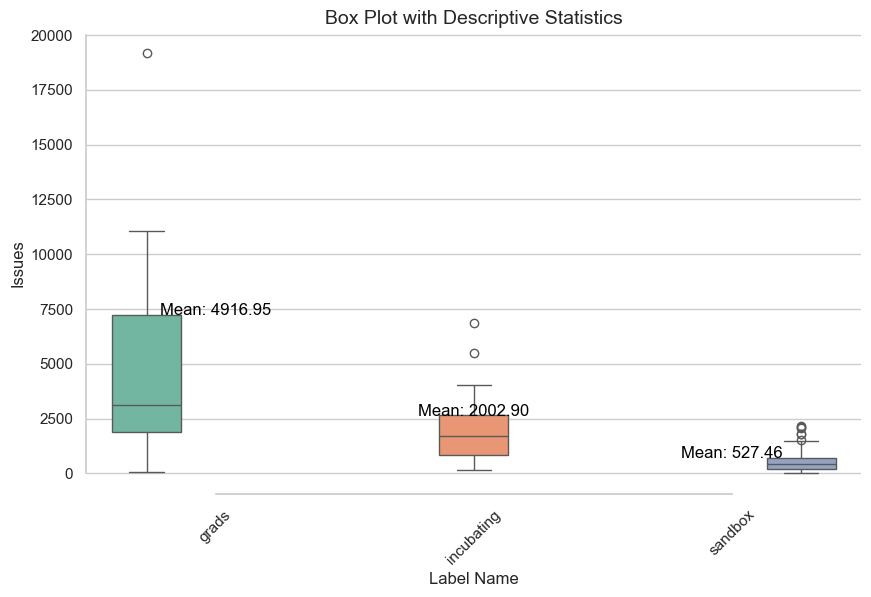

In [7]:
# Set plots style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# Create a boxplot
ax = sns.boxplot(x='label_name', y='issues', data=commitSelectedVar_filtered, palette="Set2", dodge=True, hue="label_name")

# Add mean values as text on the plot
for index, row in stats_df.iterrows():
    ax.text(
        x=index, 
        y=row['label_pos'], 
        s=f"Mean: {row['average']:.2f}", 
        color='black', 
        ha="center", 
        size=12
    )

# Set plot title and labels
ax.set_title('Box Plot with Descriptive Statistics', fontsize=14)
ax.set_xlabel('Label Name', fontsize=12)
ax.set_ylabel('Issues', fontsize=12)

# Making plot easier to read
sns.despine(trim=True)
plt.xticks(rotation=45)

plt.show()

# Start testing normality and variance homogeneous
## Distribution visualization

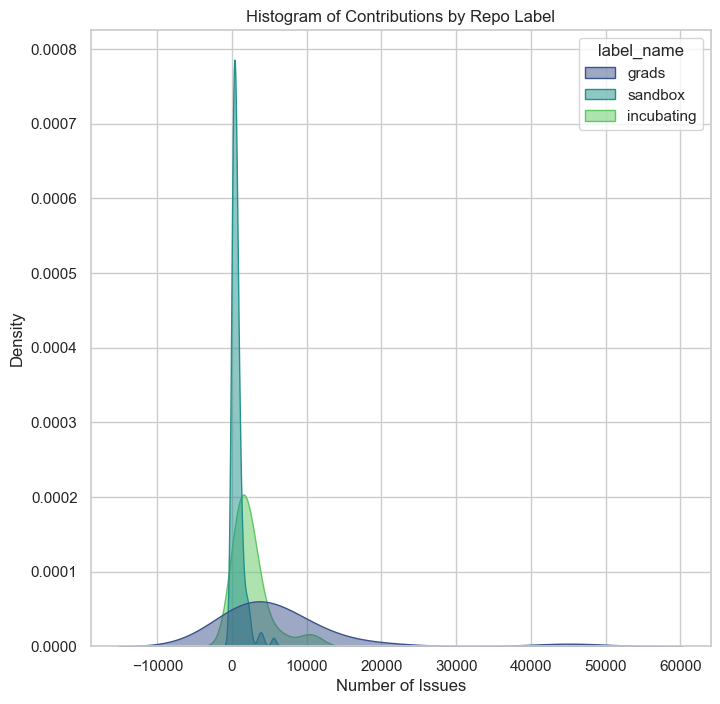

In [8]:
# Create a density plot
plt.figure(figsize=(8, 8))
#sns.kdeplot(data=commitSelectedVar, x='commits', hue='label_name', fill=True, common_norm=False, alpha=0.5, palette='coolwarm')
sns.kdeplot(data=commitSelectedVar, x='issues', hue='label_name', fill=True, common_norm=False, alpha=0.5, palette='viridis')

plt.title('Histogram of Contributions by Repo Label')
plt.xlabel('Number of Issues')
plt.ylabel('Density')
plt.show()

## Kruskal-Wallis H test to test whether there is a significant difference among pairs of groups

In [9]:
groups = [group['issues'].values for name, group in commitSelectedVar.groupby('label_name')]

# Perform Kruskal-Wallis H Test
stat, p = kruskal(*groups)
print(f'Kruskal-Wallis H Test Statistic: {stat}, P-value: {p}')


Kruskal-Wallis H Test Statistic: 62.75596434587473, P-value: 2.358932365027865e-14


## Dunn's test to conduct post-hoc test for examining the differience between each pair of groups.

In [10]:
# Conduct Dunn's Test
dunn_test_result = sp.posthoc_dunn(commitSelectedVar, val_col='issues', group_col='label_name', p_adjust='fdr_bh')

print(dunn_test_result)

                   grads    incubating       sandbox
grads       1.000000e+00  1.077410e-01  6.132728e-11
incubating  1.077410e-01  1.000000e+00  7.044411e-08
sandbox     6.132728e-11  7.044411e-08  1.000000e+00


# Summary
The number of commits is a good feature to distinguish between the pair of group of grads vs. sandbox as well as incubating vs. sandbox. However, the power of it to distinguish between the grads and incubating groups is not significantly strong. We may need to add other features, individually or go together with the feature of commit number, to distinguish groups between grads and incubating.